In [1]:
import torch
from PIL import Image
import open_clip

# Specify the path to your locally downloaded model
model_path = "marqo-gcl-vitl14-124-gs-full_states.pt"

# # Load the model and preprocessing transformations
model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14', pretrained=model_path)
tokenizer = open_clip.get_tokenizer('ViT-L-14')

c:\Users\user\anaconda3\envs\gnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
model.eval()
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 427,616,513
Context length: 77
Vocab size: 49408


In [37]:
from qdrant_client import QdrantClient
from qdrant_client.http import models as qdrant_models
from qdrant_client.models import Distance, VectorParams

qdrant_client = QdrantClient(
    url="https://daf543ed-e223-4c78-a983-9da7e433e6e1.us-east4-0.gcp.cloud.qdrant.io:6333", 
    api_key="APAxJWtNYHML7RgL6-Cruc4Yk65jex4yiKyIE_rgNI7YklAxcHI-7g",
)

print(qdrant_client.get_collections())

collections=[CollectionDescription(name='titles_collection')]


In [75]:
title = ["Earmuffs"]
inputs = tokenizer.tokenize(title).to(device)
with torch.no_grad():
    query = model.encode_text(inputs).cpu().numpy()

In [76]:
img = Image.open(r"D:\Dafa\Project\datathon-24\final\image\images_wfash\forest.jpg").convert("RGB")
img = preprocess(img).unsqueeze(0).to(device)
with torch.no_grad():
    img_embedding = model.encode_image(img).cpu().numpy()


In [57]:
title = ["white"]
inputs = tokenizer.tokenize(title).to(device)
with torch.no_grad():
    query2 = model.encode_text(inputs).cpu().numpy()

In [80]:
search_results = qdrant_client.query_points(
    collection_name="titles_collection",
     query=[img_embedding[0], query[0]],
     limit=18,
)

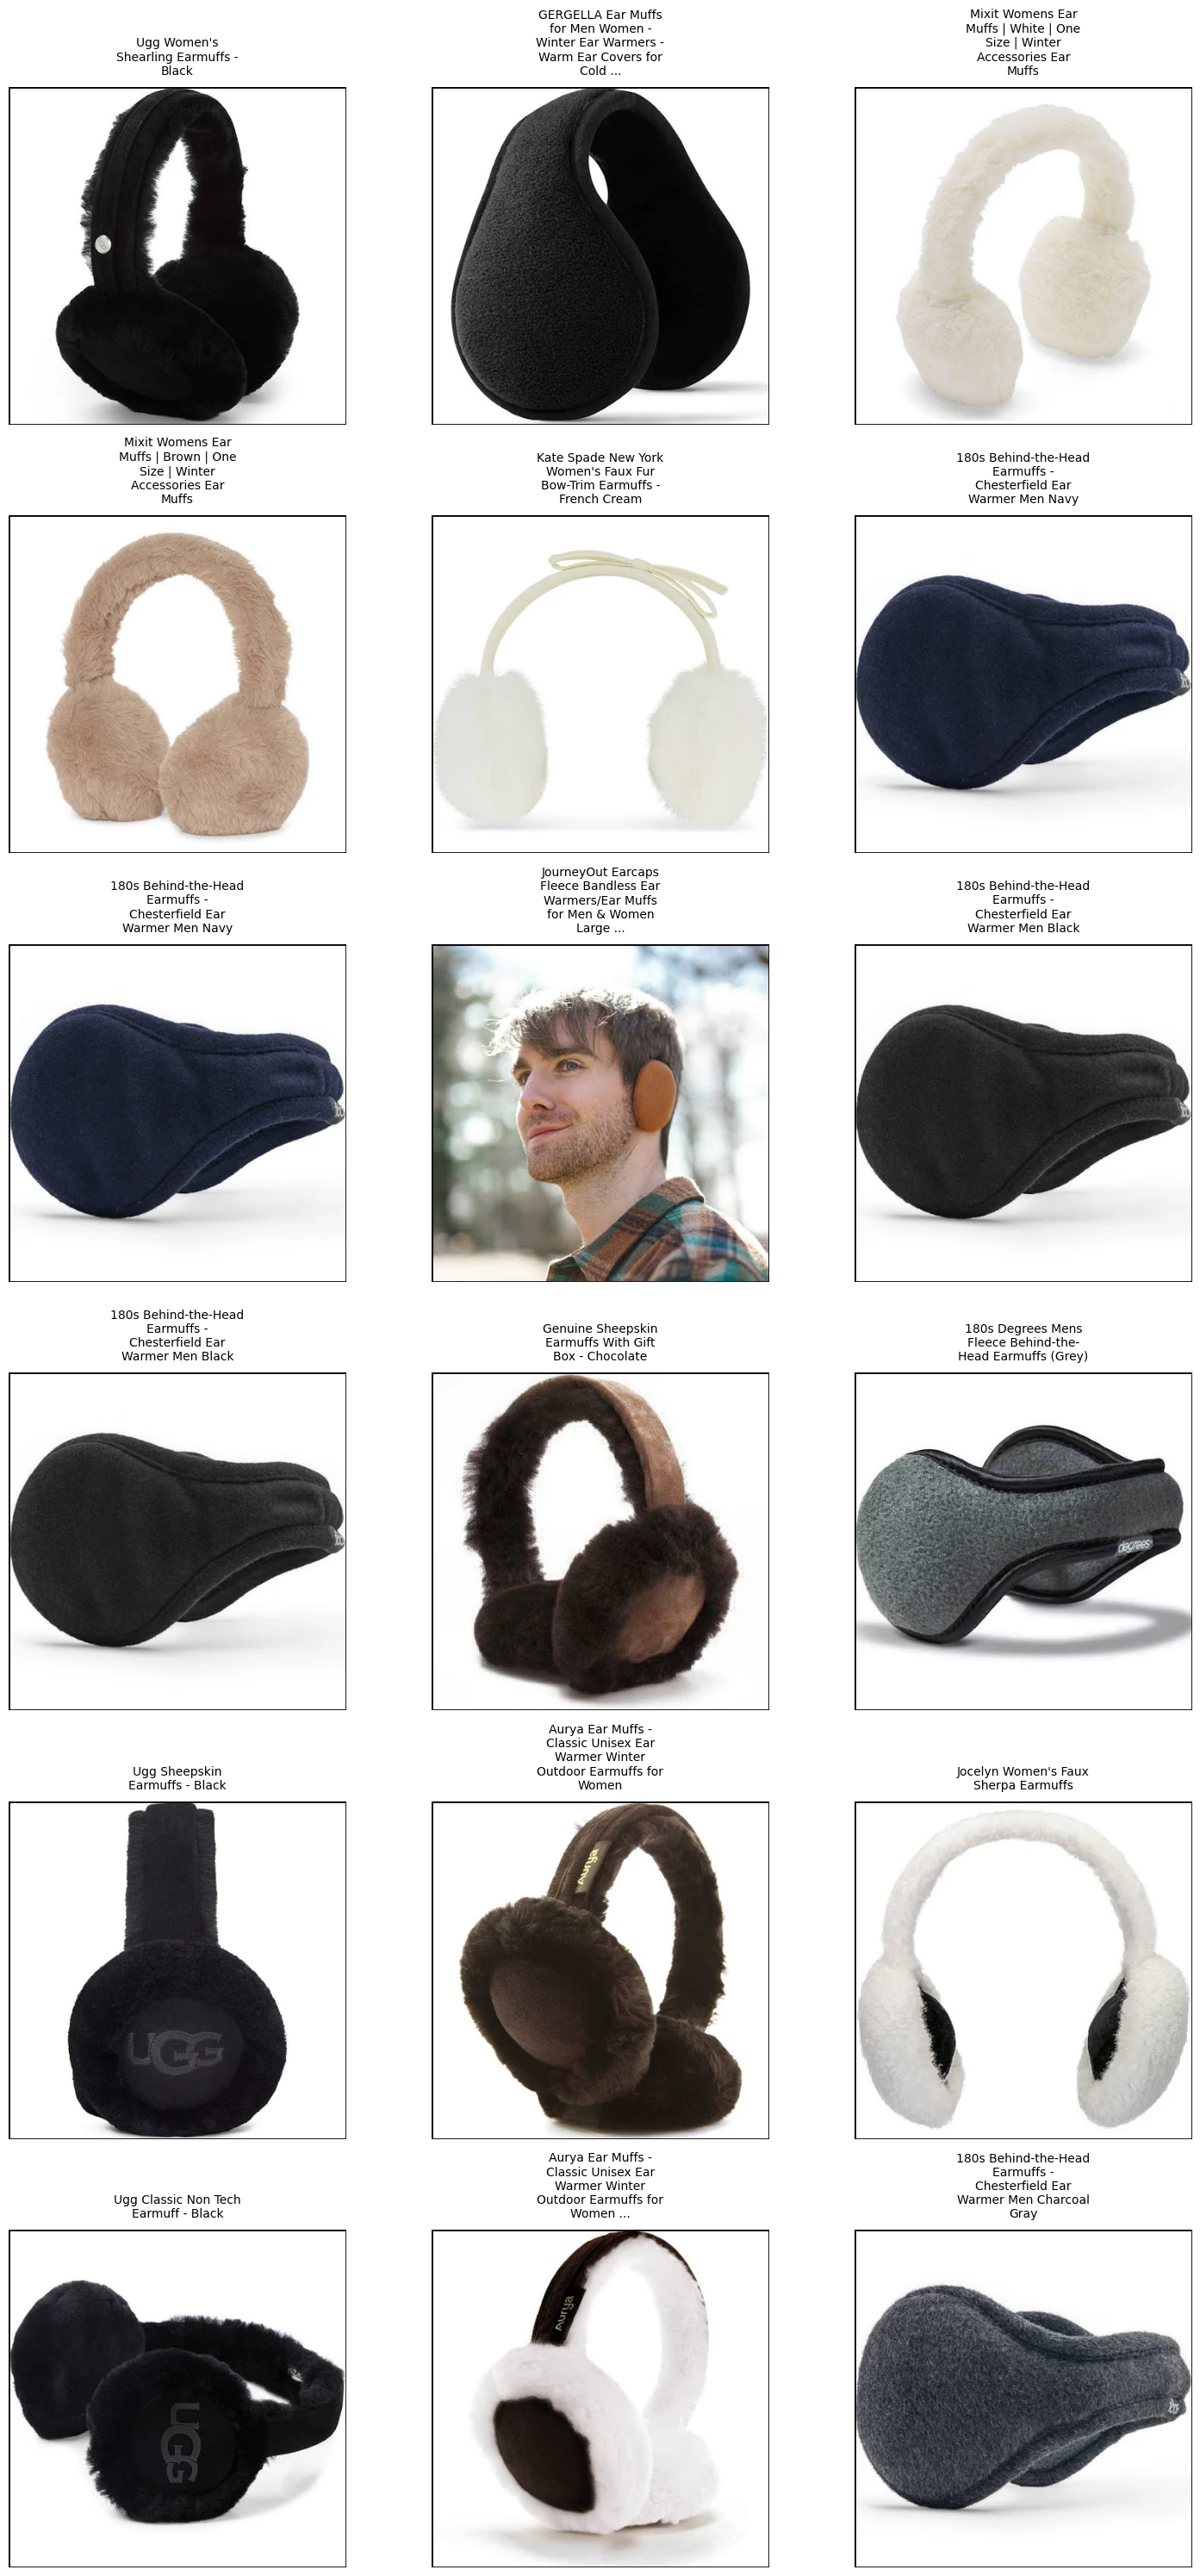

In [82]:
import os
import math
import textwrap
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

# Assuming QueryResponse and ScoredPoint are defined elsewhere
# from your_module import QueryResponse, ScoredPoint

def display_images(search_results):
    num_images = len(search_results)
    cols = 3  # Number of columns in the grid
    rows = math.ceil(num_images / cols)  # Calculate the number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

    for i, result in enumerate(search_results):
        img_id = result.id
        title = result.payload.get('title', 'No Title')
        img_path = f"../final/images_wfash/{img_id}.webp"

        if os.path.exists(img_path):
            image = Image.open(img_path).convert("RGB")
            axes[i].imshow(image)
            
            # Wrap the title to avoid overlap
            wrapped_title = "\n".join(textwrap.wrap(title, width=20))
            axes[i].set_title(wrapped_title, pad=10, fontsize=10, ha='center')
            axes[i].axis('off')

            # Add a black border around the image and title
            rect = patches.Rectangle((0, 0), 1, 1, transform=axes[i].transAxes,
                                     linewidth=2, edgecolor='black', facecolor='none')
            axes[i].add_patch(rect)
        else:
            print(f"Image {img_path} not found.")
            axes[i].axis('off')  # Hide the axis if the image is not found

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Display the images and titles
display_images(search_results.points)
# display_images(response)